In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import axes3d
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go
import plotly
import seaborn as sns

%matplotlib inline


# Operazioni su DataFrame

In [2]:
df_totale = pd.read_excel('dati_puliti_finali.xlsx')

In [3]:
df_totale.drop(columns=('Unnamed: 0'),inplace=True)


In [4]:
df_totale['wbc'].replace(3290000,3290,inplace=True)
df_totale['wbc_foll_2gg'].replace((9370000,15300000),(9370,15300),inplace=True)

In [5]:
esito_12h = list()

for row in df_totale.index:
    if df_totale['sosp_foll_12h'][row] == 2 | df_totale['sosp_foll_12h'][row] == 3  :
        esito_12h.append('morto')
    else: esito_12h.append('vivo')

In [6]:
esito_24h = esito_12h.copy()

for row in df_totale.index:
    if (df_totale['sosp_foll_24h'][row] == 2 | df_totale['sosp_foll_24h'][row] == 3) | (df_totale['deg_tot_dec'][row] == 1):
        esito_24h[row] = 'morto'

In [7]:
esito_2gg = esito_24h.copy()

for row in df_totale.index:
    if (df_totale['sosp_foll_2gg'][row] == 2 | df_totale['sosp_foll_2gg'][row] == 3) | (df_totale['deg_tot_dec'][row] == 2):
        esito_2gg[row] = 'morto'

In [8]:
esito_3gg = esito_2gg.copy()

for row in df_totale.index:
    if (df_totale['sosp_foll_3gg'][row] == 2 | df_totale['sosp_foll_3gg'][row] == 3) | (df_totale['deg_tot_dec'][row] == 3):
        esito_3gg[row] = 'morto'

In [9]:
data = {'esito_12h': esito_12h, 'esito_24h': esito_24h,'esito_2gg' : esito_2gg, 'esito_3gg': esito_3gg}
df_esiti = pd.DataFrame(data=data)

In [10]:
personal_id = df_totale['record_id']

In [11]:
df_totale.drop(columns=('record_id'),inplace=True)

In [12]:
df_totale.drop(columns=('anagrafica_complete'),inplace=True)

In [13]:
df_outcome = df_totale.loc[:,'esito_ti':]

In [14]:
df_totale.drop(columns=df_outcome.columns,inplace=True)

In [15]:
df_outcome.drop(columns=('outcome_ti_complete'), inplace=True)

In [16]:
df_vis = df_totale[['vis','vis_foll_12h','vis_foll_24h','vis_foll_2gg','vis_foll_3gg']].copy()

In [17]:
df_totale.drop(columns=df_vis.columns,inplace=True)

In [18]:
media_vis = round((df_vis['vis'] + df_vis['vis_foll_12h'] + df_vis['vis_foll_24h'] +\
                   df_vis['vis_foll_2gg']+df_vis['vis_foll_3gg'])/5)
df_vis['media_vis'] = media_vis

In [19]:
df_score = df_totale[['sofa_score','ap2_total_score','saps_totale','sofa_score_foll_12h','sofa_score_foll_24h','sofa_score_foll_2gg','sofa_score_foll_3gg']].copy()

In [20]:
df_totale.drop(columns=df_score.columns, inplace=True)

In [21]:
df_score['sofa_score_foll_12h'] = df_score['sofa_score_foll_12h'].replace(0,25)
df_score['sofa_score_foll_24h'] = df_score['sofa_score_foll_24h'].replace(0,25)
df_score['sofa_score_foll_2gg'] = df_score['sofa_score_foll_2gg'].replace(0,25)
df_score['sofa_score_foll_3gg'] = df_score['sofa_score_foll_3gg'].replace(0,25)

In [22]:
delta_12h = df_score['sofa_score_foll_12h'] - df_score['sofa_score']
delta_24h = df_score['sofa_score_foll_24h'] - df_score['sofa_score_foll_12h']
delta_2gg = df_score['sofa_score_foll_2gg'] - df_score['sofa_score_foll_24h']
delta_3gg = df_score['sofa_score_foll_3gg'] - df_score['sofa_score_foll_2gg']

In [23]:
df_score['delta_12h'] = delta_12h
df_score['delta_24h'] = delta_24h
df_score['delta_2gg'] = delta_2gg
df_score['delta_3gg'] = delta_3gg

In [24]:
mean_sofa_score = round((df_score['sofa_score'] + df_score['sofa_score_foll_12h'] + df_score['sofa_score_foll_24h'] +\
                   df_score['sofa_score_foll_2gg'] + df_score['sofa_score_foll_3gg']) / 5)

In [25]:
df_score['mean_sofa'] = mean_sofa_score

In [26]:
df_score

sofa_score  ap2_total_score  saps_totale  sofa_score_foll_12h  \
0            11               17           41                   10   
1             6               20           34                    5   
2             5               13           31                    5   
3             7               17           45                    6   
4            11               23           56                   10   
..          ...              ...          ...                  ...   
270           4               21           55                    4   
271          18               38           96                   25   
272          12               39           79                    7   
273          14               22           56                   13   
274          15               21           88                   15   

     sofa_score_foll_24h  sofa_score_foll_2gg  sofa_score_foll_3gg  delta_12h  \
0                      8                    7                   10         -1   
1                     11                   10                   10         -1   
2                      6                    4                    4          0   
3                     10                    9                   11         -1   
4                      9                    9                    9         -1   
..                   ...                  ...                  ...        ...   
270                    3                    4                    4          0   
271                   25                   25                   25          7   
272                   10                    5                    2         -5   
273                   12                   11                   11         -1   
274                   14                   16                   25          0   

     delta_24h  delta_2gg  delta_3gg  mean_sofa  
0           -2         -1          3        9.0  
1            6         -1          0        8.0  
2            1         -2          0        5.0  
3            4         -1          2        9.0  
4           -1          0          0       10.0  
..         ...        ...        ...        ...  
270         -1          1          0        4.0  
271          0          0          0       24.0  
272          3         -5         -3        7.0  
273         -1         -1          0       12.0  
274         -1          2          9       17.0  

[275 rows x 12 columns]

In [27]:
df_sepsi = df_totale[['sep','sep_foll_12h','sep_foll_24h','sep_foll_2gg','sep_foll_3gg']]

In [28]:
df_totale.drop(columns=['diff_sofa_score_foll_12h','diff_sofa_score_foll_24h','diff_sofa_score_foll_2gg',\
                        'diff_sofa_score_foll_3gg'],inplace=True)

In [29]:
df_totale

tip_paz  tip_ricov_chirurg  tip_paz_chirurgico  obiet_ricov_ti___1  \
0          1                  0                   0                   1   
1          1                  0                   0                   1   
2          1                  0                   0                   1   
3          1                  0                   0                   1   
4          1                  0                   0                   1   
..       ...                ...                 ...                 ...   
270        1                  0                   0                   0   
271        2                  2                   1                   1   
272        1                  0                   0                   1   
273        1                  0                   0                   1   
274        1                  0                   0                   1   

     obiet_ricov_ti___2  obiet_ricov_ti___3  obiet_ricov_ti___4  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
270                   1                   0                   0   
271                   1                   1                   0   
272                   1                   1                   0   
273                   1                   1                   0   
274                   1                   1                   1   

     obiet_ricov_ti___5  obiet_ricov_ti___6  maschio  ...  pc_foll_3gg  \
0                     0                   0        1  ...         23.0   
1                     0                   0        1  ...         42.0   
2                     0                   0        1  ...          2.8   
3                     0                   0        1  ...         14.0   
4                     0                   0        1  ...        192.3   
..                  ...                 ...      ...  ...          ...   
270                   0                   0        1  ...         55.0   
271                   0                   0        1  ...          0.0   
272                   0                   0        0  ...        185.0   
273                   1                   0        1  ...        195.0   
274                   0                   0        1  ...          0.0   

     end_act_assay_foll_3gg  ferr_foll_3gg  wbc_foll_3gg  gcs_sofa_foll_3gg  \
0                       0.0          552.0       14200.0                  1   
1                       0.0          312.0        9200.0                  2   
2                       0.0          112.0        4800.0                  1   
3                       0.0          123.0        7800.0                  2   
4                       0.0          212.0        7800.0                  3   
..                      ...            ...           ...                ...   
270                     0.0            0.0       14000.0                  0   
271                     0.0            0.0           0.0                  0   
272                     0.0            0.0        7420.0                  0   
273                     0.0            0.0       28830.0                  4   
274                     0.0            0.0           0.0                  0   

     resp_sofa_foll_3gg  hypotension_sofa_foll_3gg  bili_sofa_foll_3gg  \
0                     3                          0                   2   
1                     3                          4                   0   
2                     3                          0                   0   
3                     4                          4                   1   
4                     3                          0                   1   
..               

# PCA SOLO DATI CLINICI


## Calcolo della PCA tempo 0

In [29]:
df_clinico = df_totale.copy()

In [30]:
df_clinico_tempo0 = df_clinico.loc[:,:'morta_saps']

In [31]:
df_clinico_tempo0_noscore = df_clinico_tempo0.loc[:,:'wbc']

In [32]:
df_clinico_tempo0_noscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Columns: 148 entries, tip_paz to wbc
dtypes: float64(50), int64(98)
memory usage: 318.1 KB


In [33]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(df_clinico_tempo0_noscore)
df_minmax_tempo0 = minmax_scaler.transform(df_clinico_tempo0_noscore)

In [34]:
pca_2d = PCA(n_components=2).fit(df_minmax_tempo0)
df_pca_2d_t0 = pd.DataFrame(pca_2d.transform(df_minmax_tempo0))

In [35]:
pca_3d = PCA(n_components=3).fit(df_minmax_tempo0)
df_pca_3d_t0 = pd.DataFrame(pca_3d.transform(df_minmax_tempo0))

In [36]:
pca_prova = PCA(n_components=0.80).fit(df_minmax_tempo0)
df_pca_prova = pd.DataFrame(pca_prova.transform(df_minmax_tempo0))

In [37]:
df_pca_prova

0         1         2         3         4         5         6   \
0   -0.572835  1.837662  0.856277 -0.954102  0.282773 -0.035285 -0.346815   
1   -0.391095  2.019910  0.453992 -0.509996 -0.028062 -0.182403 -0.521195   
2    0.488830  2.370150  1.028656 -0.996407  0.581246  0.218008 -0.007031   
3   -0.387184  1.701296  0.937348  0.049547 -0.577016 -0.177249 -0.323893   
4   -0.756947  1.682353  0.418407 -0.165462 -0.526226 -0.078830 -0.682513   
..        ...       ...       ...       ...       ...       ...       ...   
270  2.283733  2.241331  0.293229  0.169311 -0.099050 -0.642933  0.023170   
271  0.289668 -1.851662  0.076095 -0.787911  0.225349  0.090976 -0.022851   
272  1.904753  0.464816 -0.821185  0.685726 -0.068057 -1.091550  0.988740   
273 -0.076527 -0.562664 -0.886518 -0.458615  1.375033 -0.184835 -0.660378   
274  0.451122 -0.991174 -0.534882  0.216652 -0.399705 -0.398938  0.668735   

           7         8         9   ...        22        23        24  \
0   -0.706245 -0.330530  0.378426  ... -0.004448 -0.007936  0.047914   
1   -0.255379  0.263752  0.124581  ... -0.039008  0.172506  0.126868   
2   -0.633714 -0.290628  0.184023  ... -0.186837 -0.164574 -0.112817   
3   -0.935560  0.566322  0.633405  ... -0.426576  0.483833  0.290217   
4   -0.112181  0.599339  0.144356  ... -0.212971  0.156601  0.657393   
..        ...       ...       ...  ...       ...       ...       ...   
270 -1.119728  0.867170 -0.482086  ...  0.148723  0.797806 -0.307584   
271 -0.887110 -0.626851 -0.021055  ...  0.935553 -0.401424  0.025975   
272 -0.537020 -0.711825  0.735821  ...  0.082881  0.395471 -1.007543   
273 -0.495798 -0.352723 -0.168272  ...  0.410666 -0.207408  0.959426   
274 -0.618247  0.261885 -0.353173  ...  0.447378  0.023867  0.706090   

           25        26        27        28        29        30        31  
0    0.023778  0.528407 -0.203617  0.361380  0.112940  0.057503  0.081014  
1   -0.225489  0.229048 -0.411173  0.387149 -0.136898  0.246374  0.093277  
2   -0.266886  0.093114  0.343407  0.330313  0.407679 -0.236387  0.241531  
3    0.160731 -0.200808  0.027059  0.135519  0.203362  0.076237 -0.542228  
4   -0.366946  0.249830 -0.170519  0.416910 -0.149898  0.060114 -0.131789  
..        ...       ...       ...       ...       ...       ...       ...  
270  0.368011 -0.843257 -0.438776 -0.512967  0.160826 -0.228375  0.049550  
271  0.434340 -0.169693 -0.116358 -0.016318  0.158934 -0.085873 -0.209592  
272  0.962904 -0.034456 -0.530349 -0.373604  0.742152 -0.024202  0.042505  
273 -0.011804 -0.405106 -0.608586 -0.343936  0.094546  0.017607  0.063431  
274  0.110438 -0.405467 -0.004912  0.038554  0.436564 -0.267923 -0.371193  

[275 rows x 32 columns]

## K-mean

overall clustering silhouette 0.05715869474641367


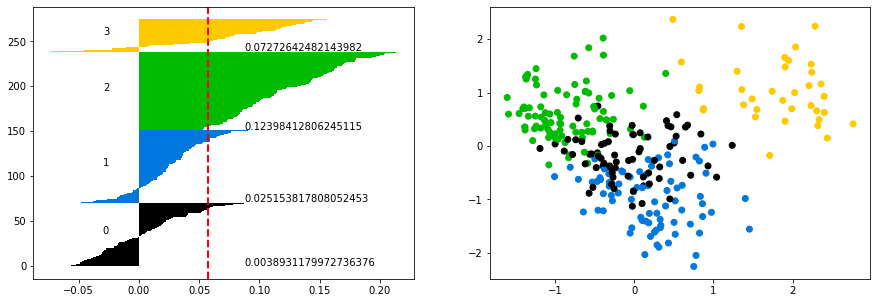

In [38]:
K=4
kmeans_model = KMeans(n_clusters=K, init='random', n_init=10)
kmeans_model.fit(df_minmax_tempo0)
y = kmeans_model.labels_


silhouette_avg = silhouette_score(df_minmax_tempo0, y) #silhouette media
sample_silhouette_values = silhouette_samples(df_minmax_tempo0, y)

print(f'overall clustering silhouette {silhouette_avg}')

fig, ax = plt.subplots(1,2,figsize=(15,5))

y_lower = 0 
y_upper = 0
for i,cluster in enumerate(np.unique(y)):
    cluster_silhouette_vals = sample_silhouette_values[y == cluster]
    cluster_silhouette_vals.sort()
    cluster_silhouette_mean=cluster_silhouette_vals.mean()
    y_upper += len(cluster_silhouette_vals)
    color = cm.nipy_spectral(float(i) / K)
    ax[0].barh(range(y_lower,y_upper), cluster_silhouette_vals, height=1, color=color)
    ax[0].text(-0.03, (y_lower+y_upper)/2, str(i))
    ax[0].text(silhouette_avg+0.03, y_lower, cluster_silhouette_mean)  
    y_lower += len(cluster_silhouette_vals)

ax[0].axvline(silhouette_avg, linestyle ='--', linewidth =2, color = 'red')
colors = cm.nipy_spectral(y.astype(float) / K)

ax[1].scatter(df_pca_2d_t0.iloc[:, 0], df_pca_2d_t0.iloc[:, 1], c=colors)
plt.show()

overall clustering silhouette 0.12582463825940765


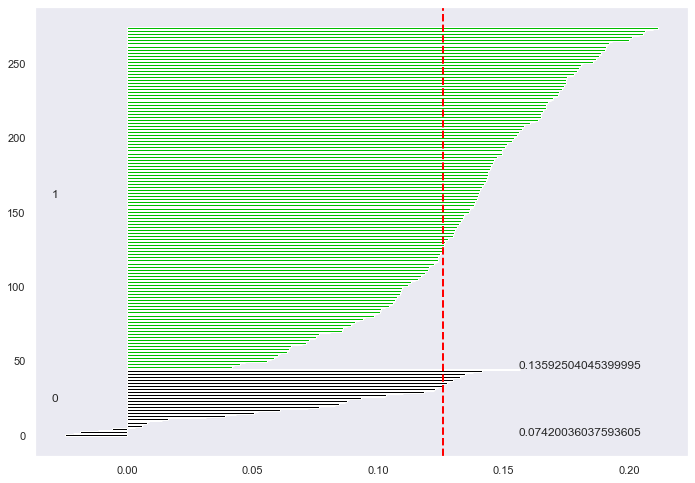

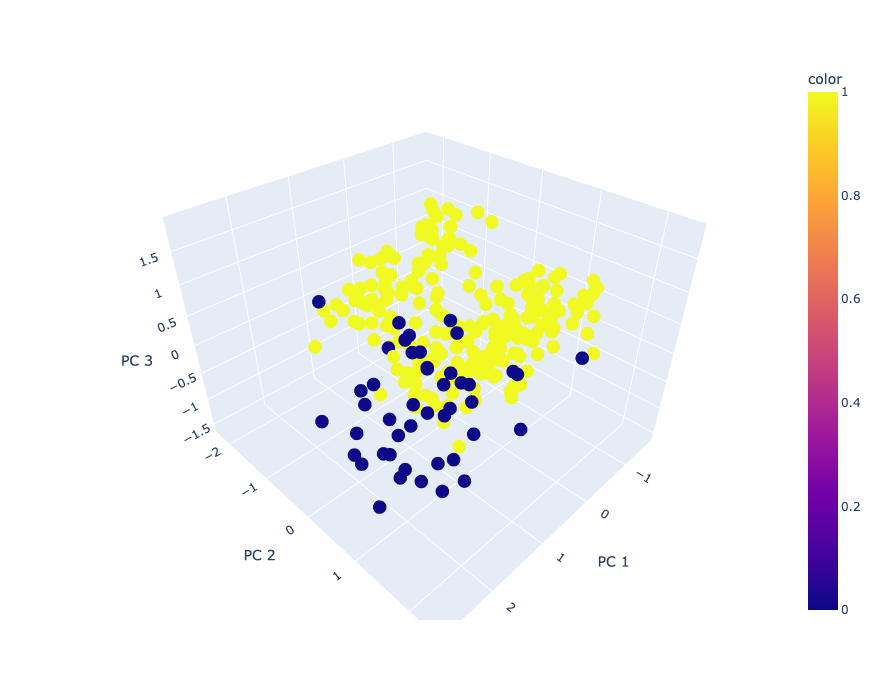

In [87]:
K=2
kmeans_model = KMeans(n_clusters=K, init='random', n_init=10)
kmeans_model.fit(df_minmax_tempo0)
y = kmeans_model.labels_


silhouette_avg = silhouette_score(df_minmax_tempo0, y) #silhouette media
sample_silhouette_values = silhouette_samples(df_minmax_tempo0, y)

print(f'overall clustering silhouette {silhouette_avg}')

y_lower = 0 
y_upper = 0
for i,cluster in enumerate(np.unique(y)):
    cluster_silhouette_vals = sample_silhouette_values[y == cluster]
    cluster_silhouette_vals.sort()
    cluster_silhouette_mean=cluster_silhouette_vals.mean()
    y_upper += len(cluster_silhouette_vals)
    color = cm.nipy_spectral(float(i) / K)
    plt.barh(range(y_lower,y_upper), cluster_silhouette_vals, height=1, color=color)
    plt.text(-0.03, (y_lower+y_upper)/2, str(i))
    plt.text(silhouette_avg+0.03, y_lower, cluster_silhouette_mean)  
    y_lower += len(cluster_silhouette_vals)

plt.axvline(silhouette_avg, linestyle ='--', linewidth =2, color = 'red')
colors = cm.nipy_spectral(y.astype(float) / K)
plt.show()

px.scatter_3d(
        df_pca_3d_t0, x=0, y=1, z=2, color=y,
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        height=700
    )

In [88]:
y

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [103]:
cluster = pd.DataFrame((personal_id,y)).transpose()

In [107]:
cluster['record_id'].loc[cluster['Unnamed 0'] ==0].to_csv('record_cluster1.csv')

In [108]:
cluster['record_id'].loc[cluster['Unnamed 0'] ==1].to_csv('record_cluster2.csv')

## Distribuzione delle feature rispetto alle componenti

A seguire vediamo come si distribuiscono le feature rispetto alle componenti, le consideriamo ordinate secondo il contributo che danno alla componente 

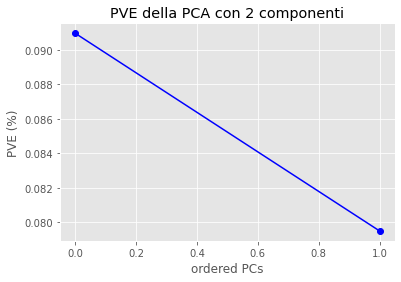

PVE :  [0.09095903 0.07950189]
Varianza totale :  0.17046091908325972


In [40]:
plt.style.use("ggplot") 
plt.plot(pca_2d.explained_variance_ratio_, marker='o', color='blue')
plt.title('PVE della PCA con 2 componenti')
plt.xlabel('ordered PCs')
plt.ylabel('PVE (%)')
plt.show()
print('PVE : ', pca_2d.explained_variance_ratio_)
print('Varianza totale : ',np.sum(pca_2d.explained_variance_ratio_))

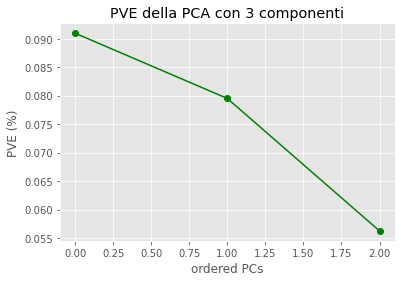

PVE :  [0.09095903 0.07950189 0.05624059]
Varianza totale :  0.22670150598615194


In [41]:
plt.style.use("ggplot") 
plt.plot(pca_3d.explained_variance_ratio_, marker='o', color='green')
plt.title('PVE della PCA con 3 componenti')
plt.xlabel('ordered PCs')
plt.ylabel('PVE (%)')
plt.show()
print('PVE : ',pca_3d.explained_variance_ratio_)
print('Varianza totale : ',np.sum(pca_3d.explained_variance_ratio_))

In [42]:
variance_ratio_2d = pca_2d.explained_variance_ratio_
cumulative_variance_ratio_2d = np.cumsum(variance_ratio_2d)
# Get the loadings (coefficients) of each principal component
loadings_2d = pca_2d.components_

In [43]:
variance_ratio_3d = pca_3d.explained_variance_ratio_
cumulative_variance_ratio_3d = np.cumsum(variance_ratio_3d)
# Get the loadings (coefficients) of each principal component
loadings_3d = pca_3d.components_

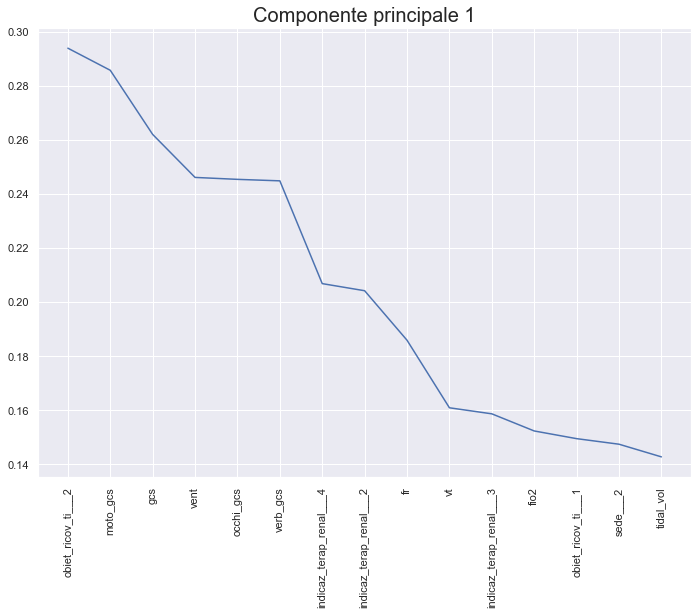

In [44]:
df_3d=pd.DataFrame(np.abs(pca_3d.components_),columns=df_clinico_tempo0_noscore.columns,index = ['PC-1','PC-2','PC-3'])
df_3d =df_3d.transpose()

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot( x=df_3d.sort_values(by='PC-1',ascending=False).index[:15], 
             y=np.array(df_3d['PC-1'].sort_values(ascending=False))[:15])
plt.title('Componente principale 1',fontdict={'fontsize':20})
plt.tick_params(axis='x', rotation=90)

plt.show()

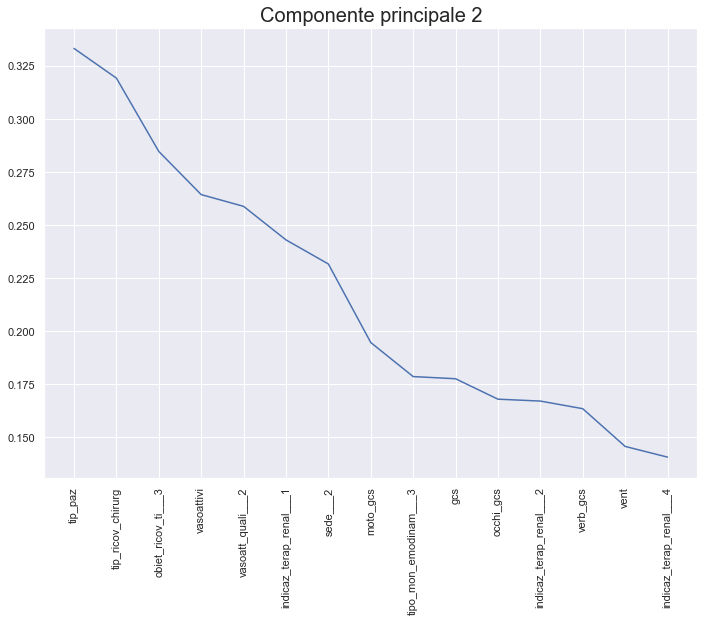

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot( x=df_3d.sort_values(by='PC-2',ascending=False).index[:15], 
             y=np.array(df_3d['PC-2'].sort_values(ascending=False))[:15])
plt.tick_params(axis='x', rotation=90)
plt.title('Componente principale 2',fontdict={'fontsize':20})

plt.show()

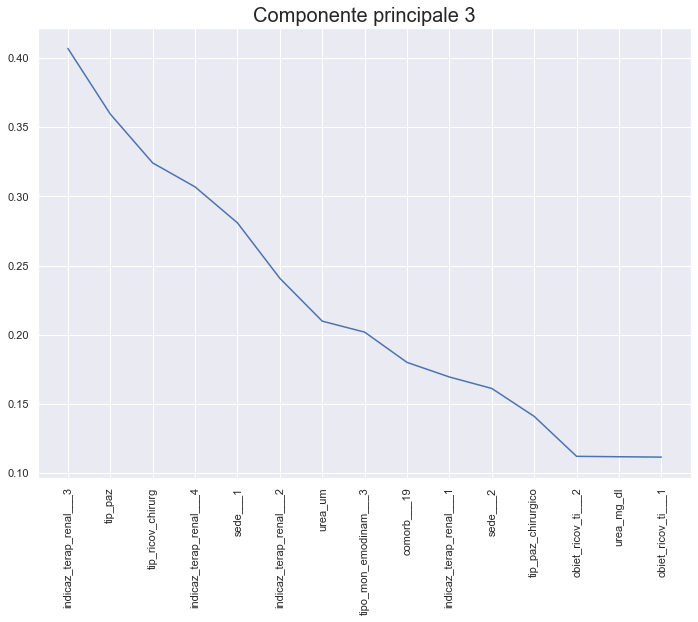

In [46]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot( x=df_3d.sort_values(by='PC-3',ascending=False).index[:15], 
             y=np.array(df_3d['PC-3'].sort_values(ascending=False))[:15])
plt.tick_params(axis='x', rotation=90)
plt.title('Componente principale 3',fontdict={'fontsize':20})

plt.show()

In [47]:
for j in range(len(loadings_2d)):
    sorted_loadings_2d = np.argsort(np.abs(loadings_2d[j]))[::-1]
    print("Features with highest loadings in Principal Component", j+1,"\n")
    for feature_idx in sorted_loadings_2d:
        print("  ", df_clinico_tempo0_noscore.columns[feature_idx], ": ", loadings_2d[j][feature_idx])
    print("\n")

Features with highest loadings in Principal Component 1 

   obiet_ricov_ti___2 :  0.2939728493827273
   moto_gcs :  0.2857876386277764
   gcs :  0.2620523005411849
   vent :  -0.2461306171760912
   occhi_gcs :  0.24541259837085255
   verb_gcs :  0.24486290456069468
   indicaz_terap_renal___4 :  0.20681498924469438
   indicaz_terap_renal___2 :  0.2041837309000683
   fr :  -0.18585701562060353
   vt :  -0.1608514232575873
   indicaz_terap_renal___3 :  0.1586139748997869
   fio2 :  -0.1522738570709506
   obiet_ricov_ti___1 :  -0.14942776701557764
   sede___2 :  0.1473678625168173
   tidal_vol :  -0.14268231092399042
   comorb___1 :  0.14187042271036077
   tip_paz :  0.13994447614852962
   a_ao2 :  -0.13630670372926443
   pos_coronavirus :  0.12737739350205113
   mod_vent :  -0.12568545069869158
   resp_spont :  0.1256711720587553
   tip_ricov_chirurg :  0.12355393034497225
   obiet_ricov_ti___3 :  0.11278714062234019
   comorb___11 :  0.10321266512099622
   indicaz_terap_renal___1 :  0.1

In [48]:
for j in range(len(loadings_3d)):
    sorted_loadings_3d = np.argsort(np.abs(loadings_3d[j]))[::-1]
    print("Features with highest loadings in Principal Component", j+1,"\n")
    for feature_idx in sorted_loadings_3d:
        print("  ", df_clinico_tempo0_noscore.columns[feature_idx], ": ", loadings_3d[j][feature_idx])
    print("\n")

Features with highest loadings in Principal Component 1 

   obiet_ricov_ti___2 :  0.2939728493827273
   moto_gcs :  0.2857876386277764
   gcs :  0.2620523005411849
   vent :  -0.2461306171760912
   occhi_gcs :  0.24541259837085255
   verb_gcs :  0.24486290456069468
   indicaz_terap_renal___4 :  0.20681498924469438
   indicaz_terap_renal___2 :  0.2041837309000683
   fr :  -0.18585701562060353
   vt :  -0.1608514232575873
   indicaz_terap_renal___3 :  0.1586139748997869
   fio2 :  -0.1522738570709506
   obiet_ricov_ti___1 :  -0.14942776701557764
   sede___2 :  0.1473678625168173
   tidal_vol :  -0.14268231092399042
   comorb___1 :  0.14187042271036077
   tip_paz :  0.13994447614852962
   a_ao2 :  -0.13630670372926443
   pos_coronavirus :  0.12737739350205113
   mod_vent :  -0.12568545069869158
   resp_spont :  0.1256711720587553
   tip_ricov_chirurg :  0.12355393034497225
   obiet_ricov_ti___3 :  0.11278714062234019
   comorb___11 :  0.10321266512099622
   indicaz_terap_renal___1 :  0.1

## Plot PCA

#### Score

In [49]:
dict_score = dict()
for col in df_score.columns:
    dict_score[col] = df_score[col]

/var/folders/n4/sslytgjx3ss97d6_s0r9dzc00000gn/T/ipykernel_40517/2080412147.py:11: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



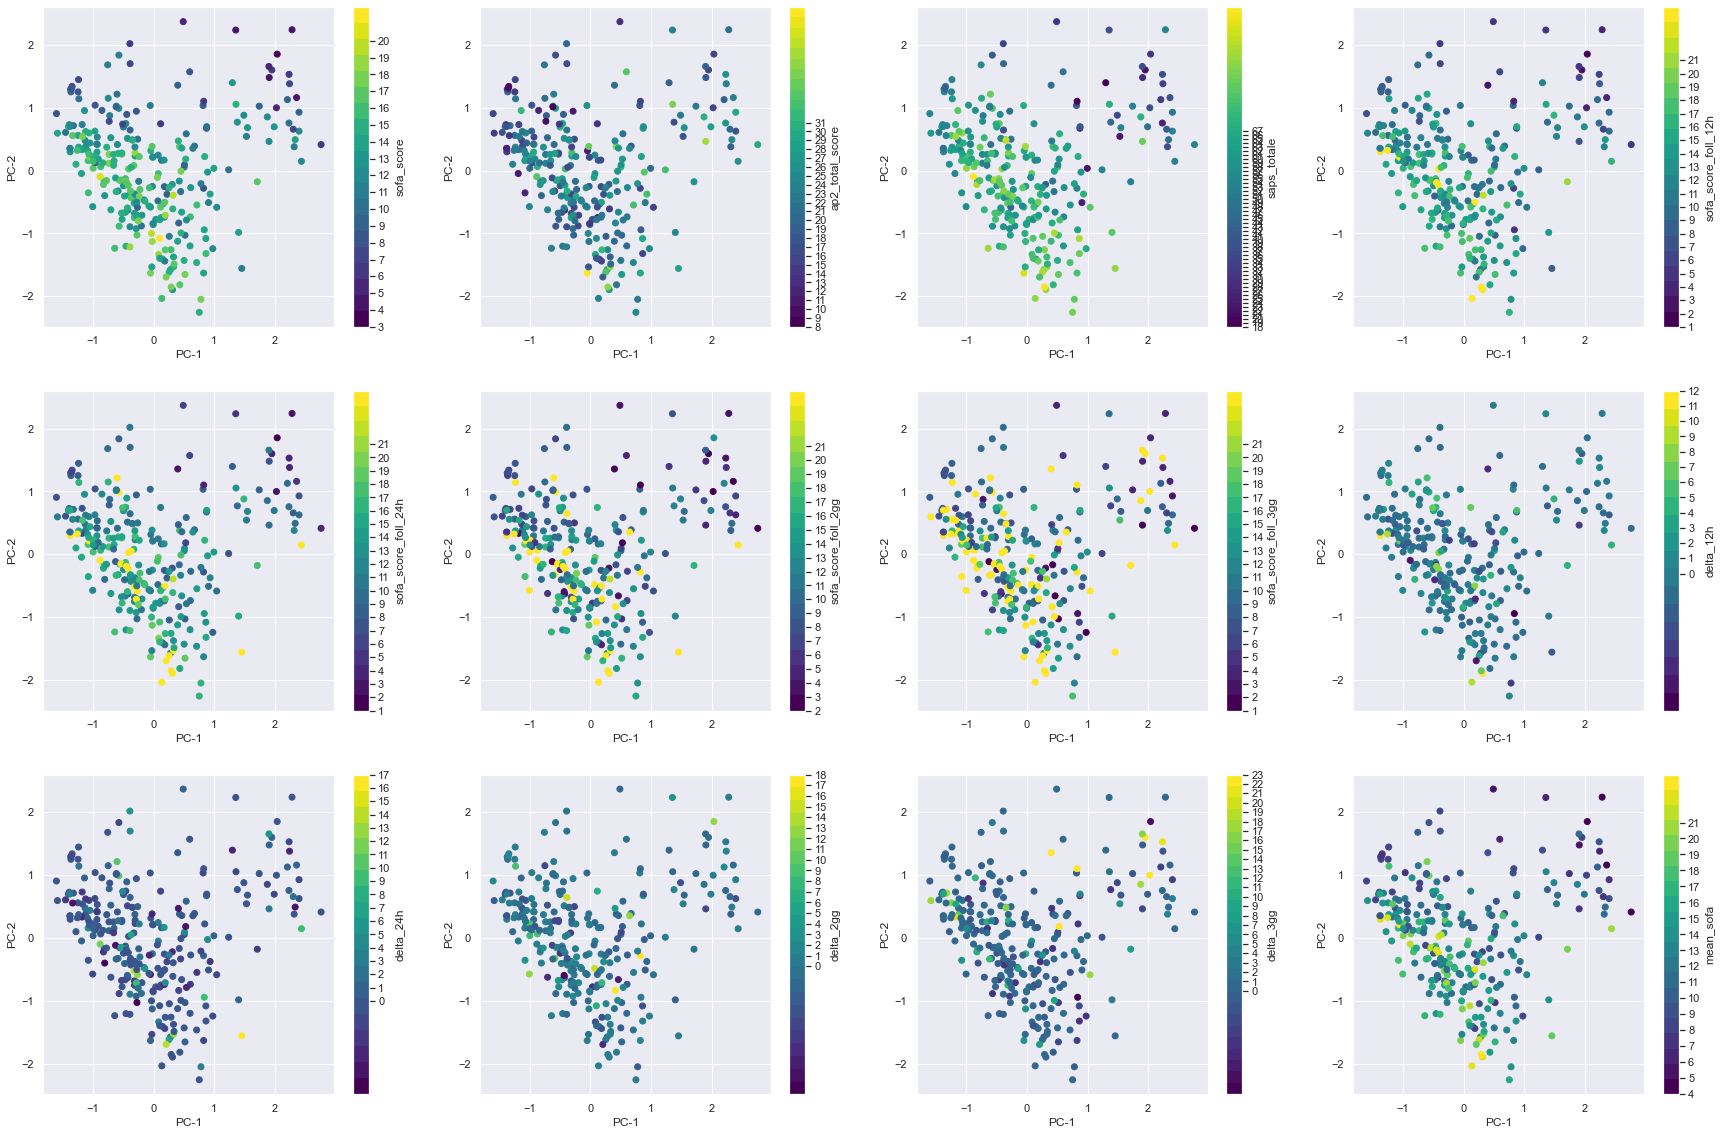

In [50]:
fig = plt.figure(figsize=(30,20))

for i in range(0,12):
    
    ax = fig.add_subplot(3, 4, i+1)
    col = df_score.columns[i]
    plot2d = ax.scatter(df_pca_2d_t0.iloc[:, 0], df_pca_2d_t0.iloc[:, 1], c=df_score[col], \
                        cmap=plt.cm.get_cmap('viridis',len(np.unique(df_score[col]))))
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    fig.colorbar(plot2d , ticks=range(len(np.unique(df_score[col]))+1), label=col)
    
plt.rcParams['axes.grid'] = False

plt.show()

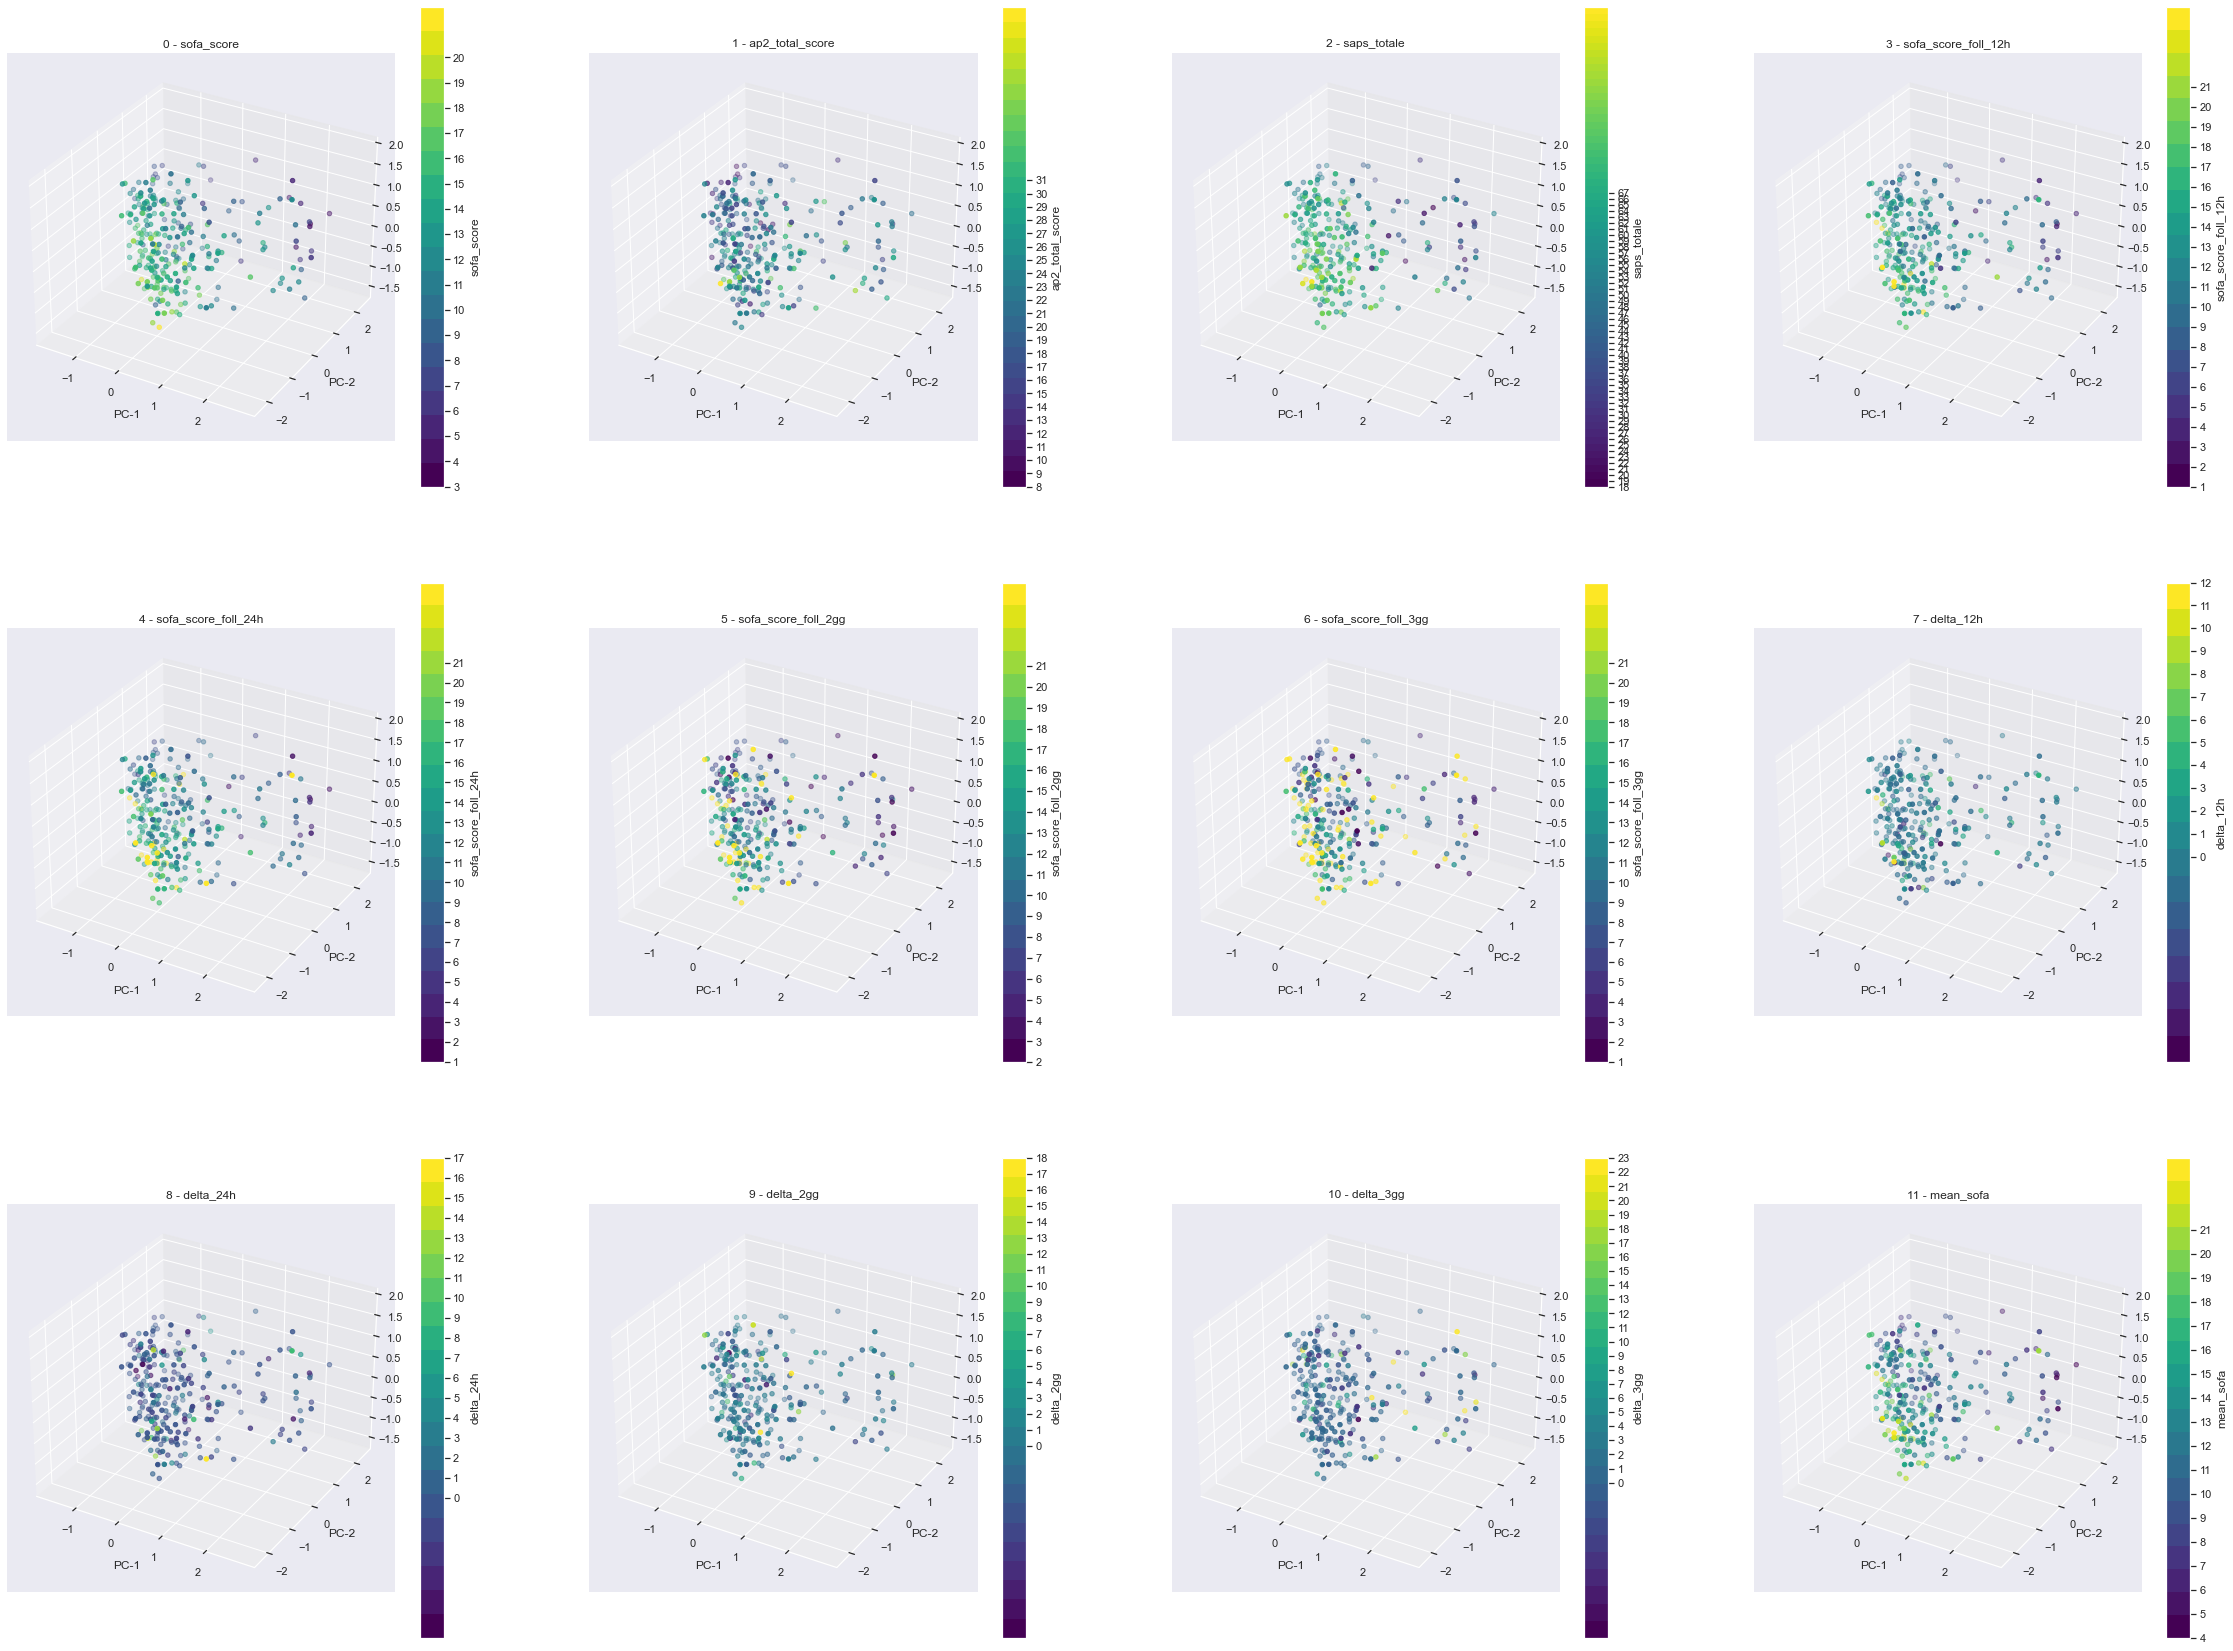

In [51]:

fig = plt.figure(figsize=(40,30))

fig1 = list()
for i in range(0,12):
    ax = fig.add_subplot(3, 4, i+1, projection='3d')
    col = df_score.columns[i]

    plot3d = ax.scatter(df_pca_3d_t0.iloc[:, 0], df_pca_3d_t0.iloc[:, 1],df_pca_3d_t0.iloc[:, 2],  c=df_score[col],\
               cmap=plt.cm.get_cmap('viridis',len(np.unique(df_score[col]))))
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    fig.colorbar(plot3d ,ticks=range(len(np.unique(df_score[col]))+1), label=col)
    plt.title(str(i) + " - " + str(col))
    
    fig1.append(px.scatter_3d(
        df_pca_3d_t0, x=0, y=1, z=2, color=df_score[col],
        color_continuous_scale=plotly.colors.sequential.Viridis,title=str(col),
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        height=700,
        )
    )
    fig1[i].update_layout(coloraxis_colorbar_title_text = col)
    
plt.rcParams['axes.grid'] = False

plt.show()

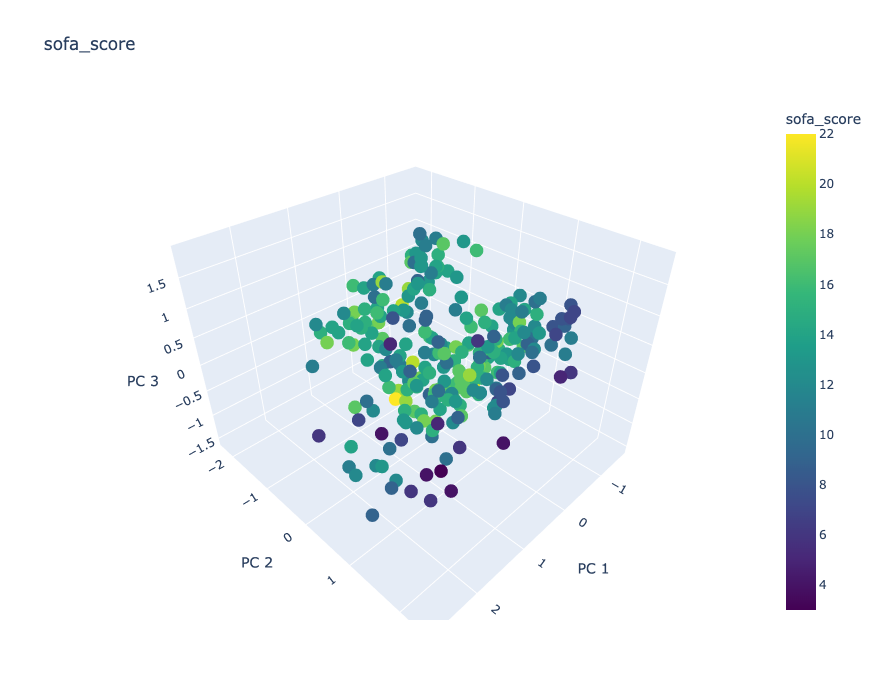

In [52]:
fig1[0]

#### Output

In [53]:
df_esiti_1 = df_esiti.copy()

In [54]:
df_esiti.replace(('vivo','morto'),(1,2),inplace=True)

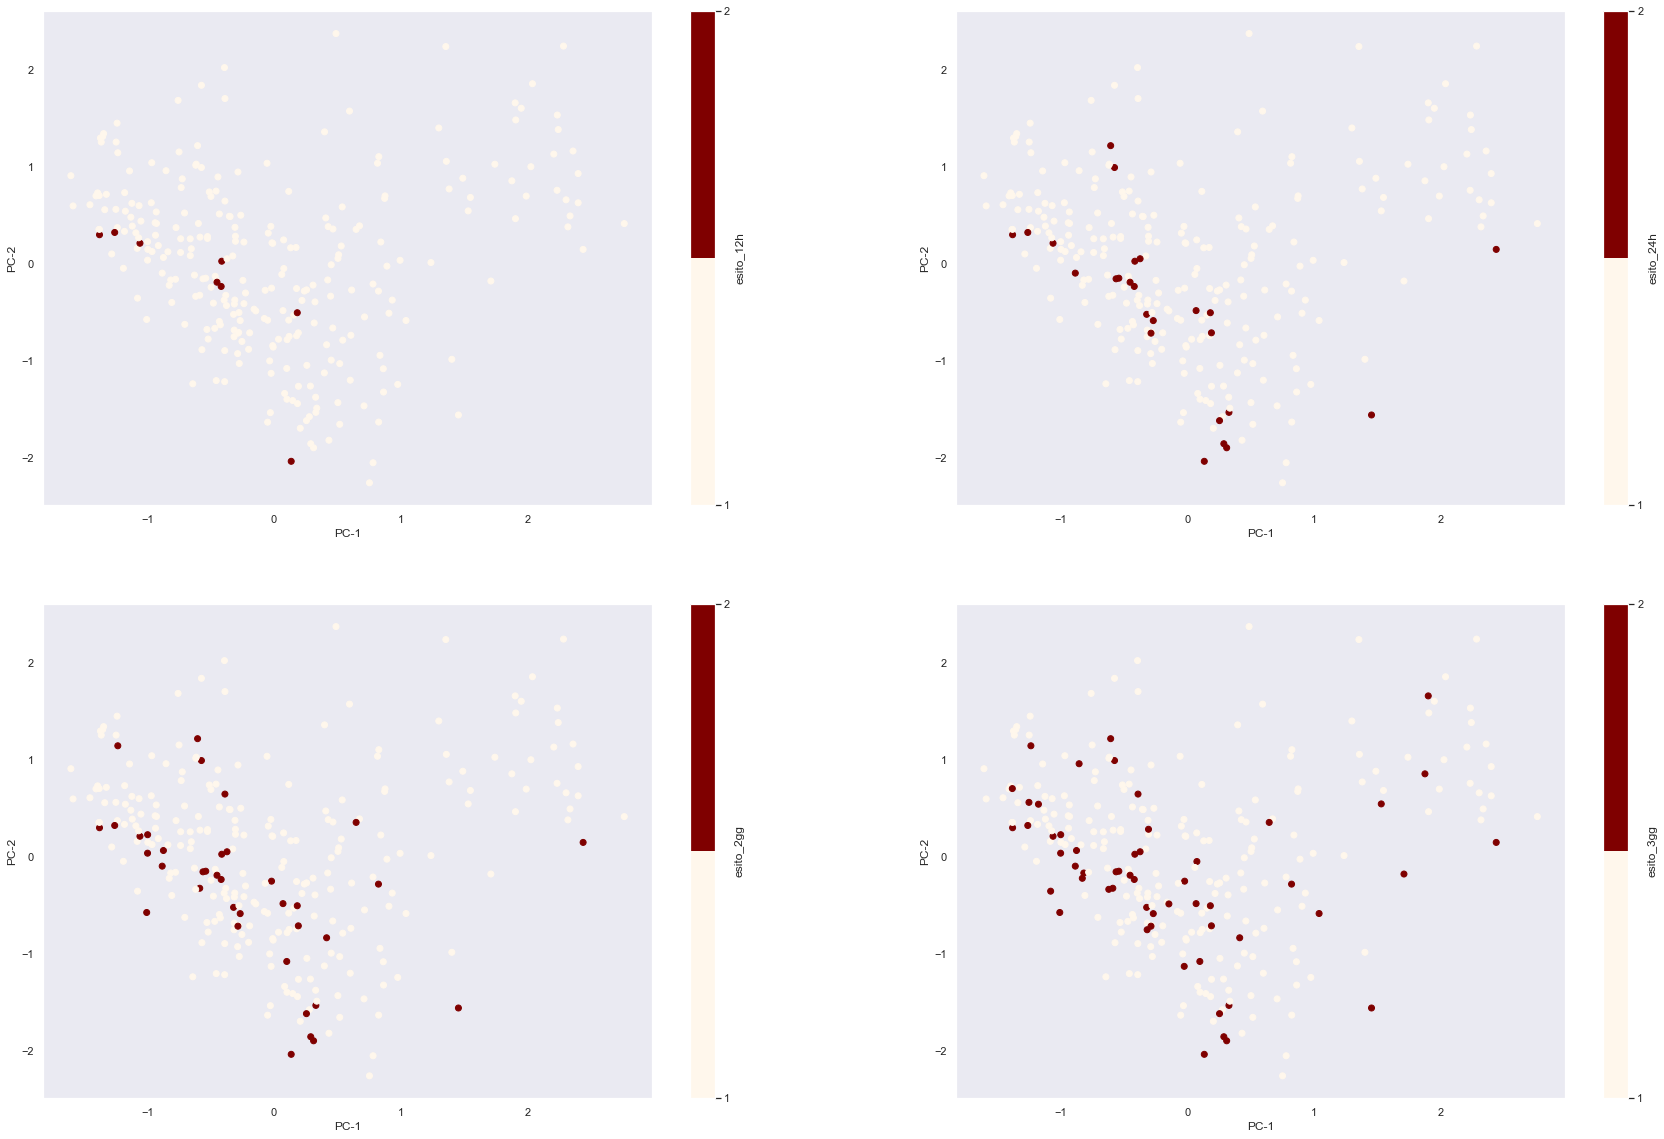

In [55]:
fig = plt.figure(figsize=(30,20))

for i in range(0,4):
    
    ax = fig.add_subplot(2, 2, i+1)
    col = df_esiti.columns[i]
    plot2d = ax.scatter(df_pca_2d_t0.iloc[:, 0], df_pca_2d_t0.iloc[:, 1], c=df_esiti.loc[:,col], cmap=plt.cm.get_cmap('OrRd',len(np.unique(df_esiti[col]))))
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    fig.colorbar(plot2d , ticks=range(len(np.unique(df_esiti[col]))+1), label=col )
    
plt.rcParams['axes.grid'] = False

plt.show()

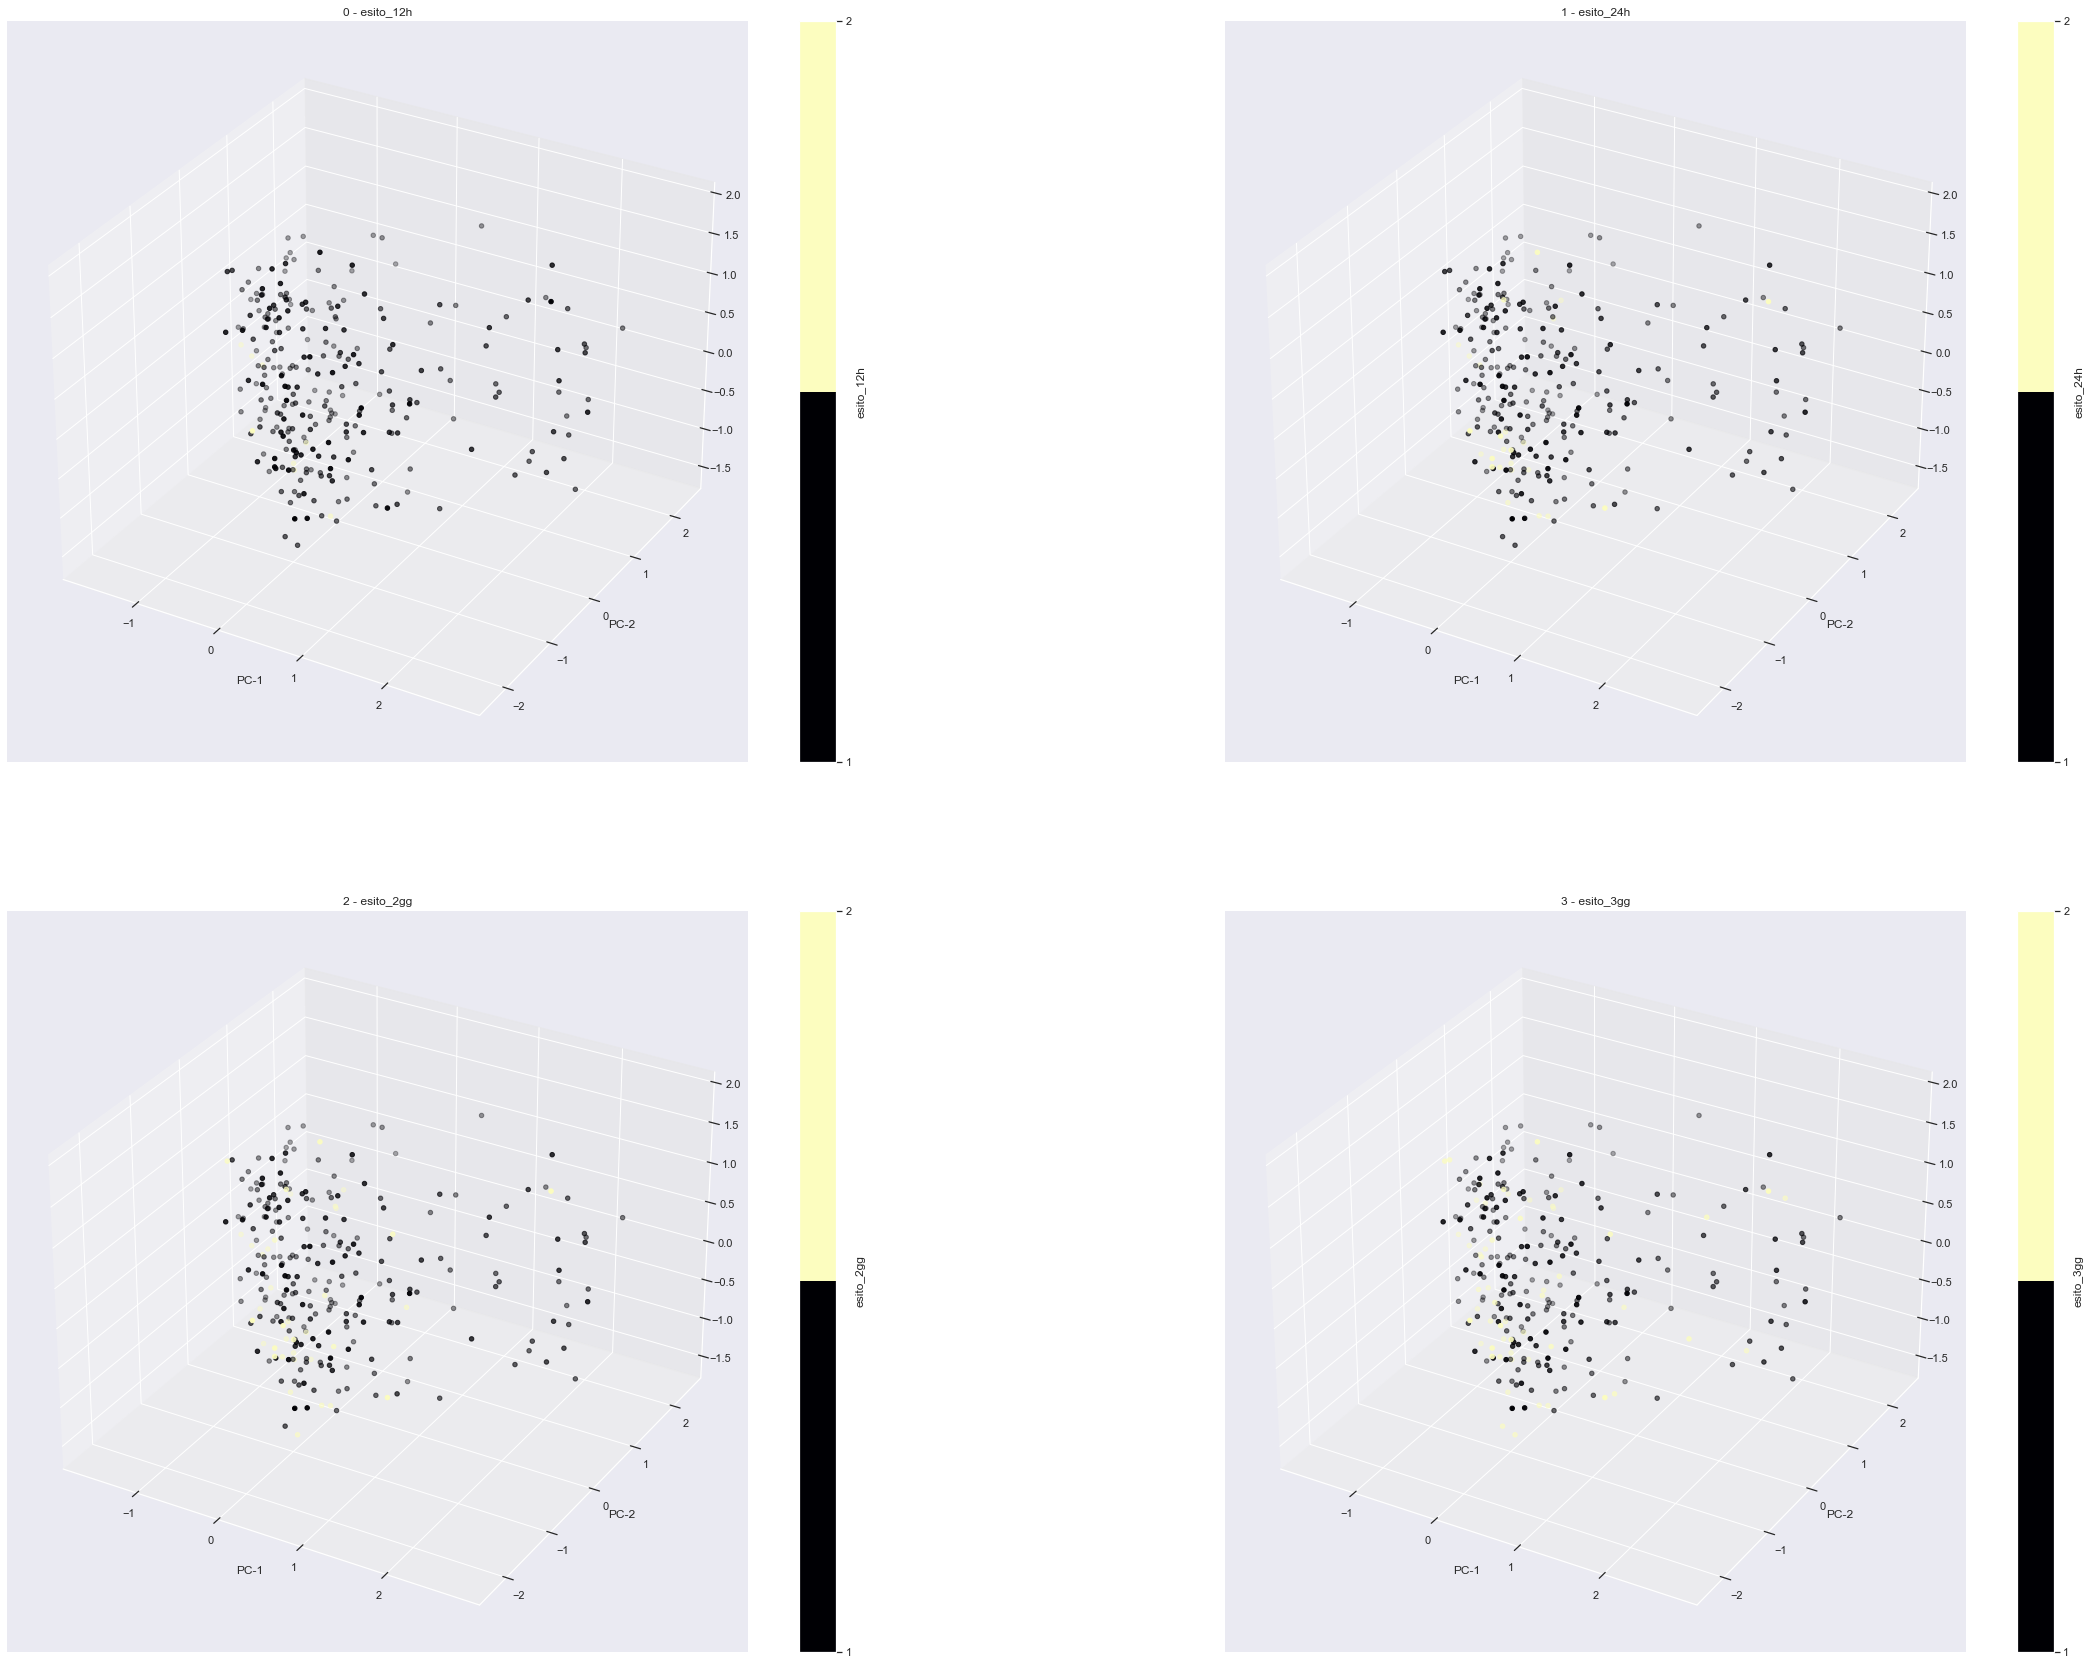

In [56]:

fig = plt.figure(figsize=(40,30))

fig2 = list()
for i in range(0,4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    col = df_esiti.columns[i]

    plot3d = ax.scatter(df_pca_3d_t0.iloc[:, 0], df_pca_3d_t0.iloc[:, 1],df_pca_3d_t0.iloc[:, 2],  c=df_esiti[col],\
               cmap=plt.cm.get_cmap('magma',len(np.unique(df_esiti[col]))))
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    fig.colorbar(plot3d ,ticks=range(len(np.unique(df_esiti[col]))+1), label=col)
    plt.title(str(i) + " - " + str(col))
    
    fig2.append(px.scatter_3d(
        df_pca_3d_t0, x=0, y=1, z=2, color=df_esiti_1[col],
        color_discrete_sequence=px.colors.qualitative.Antique,        
        title=str(col),
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        height=700
    ))
    fig2[i].update_layout(legend_title=col)
    fig2[i].update_layout(
    legend=dict(
        x=0.80,
        y=0.80,
        traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            family="Courier",
            size=12,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    ))

    
plt.rcParams['axes.grid'] = False

plt.show()

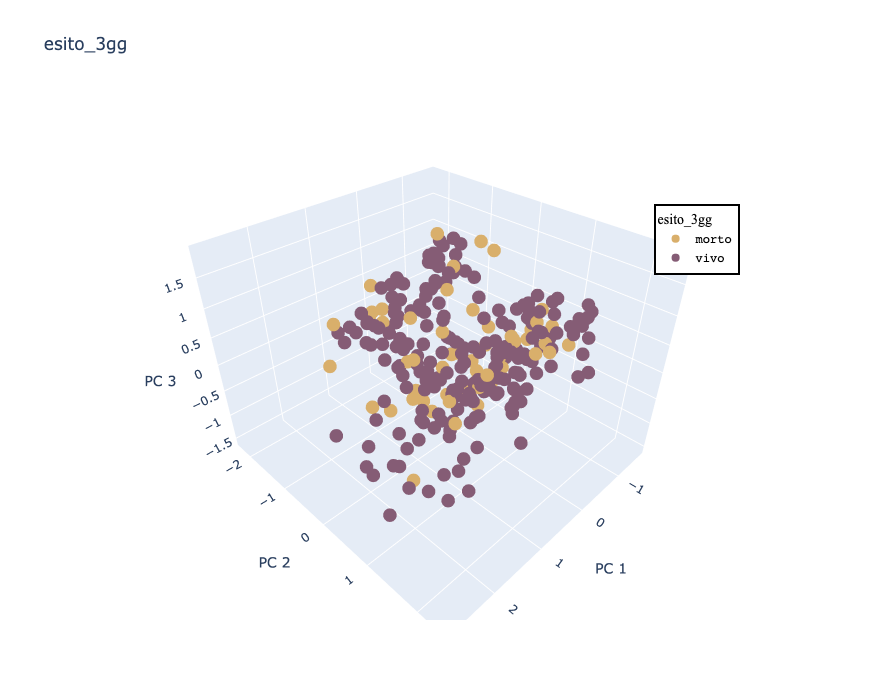

In [57]:
fig2[3]

#### Sepsi

In [58]:
df_sepsi_1 = df_sepsi.replace((0,1,2,3),('nc','no','presunta','accertata'))

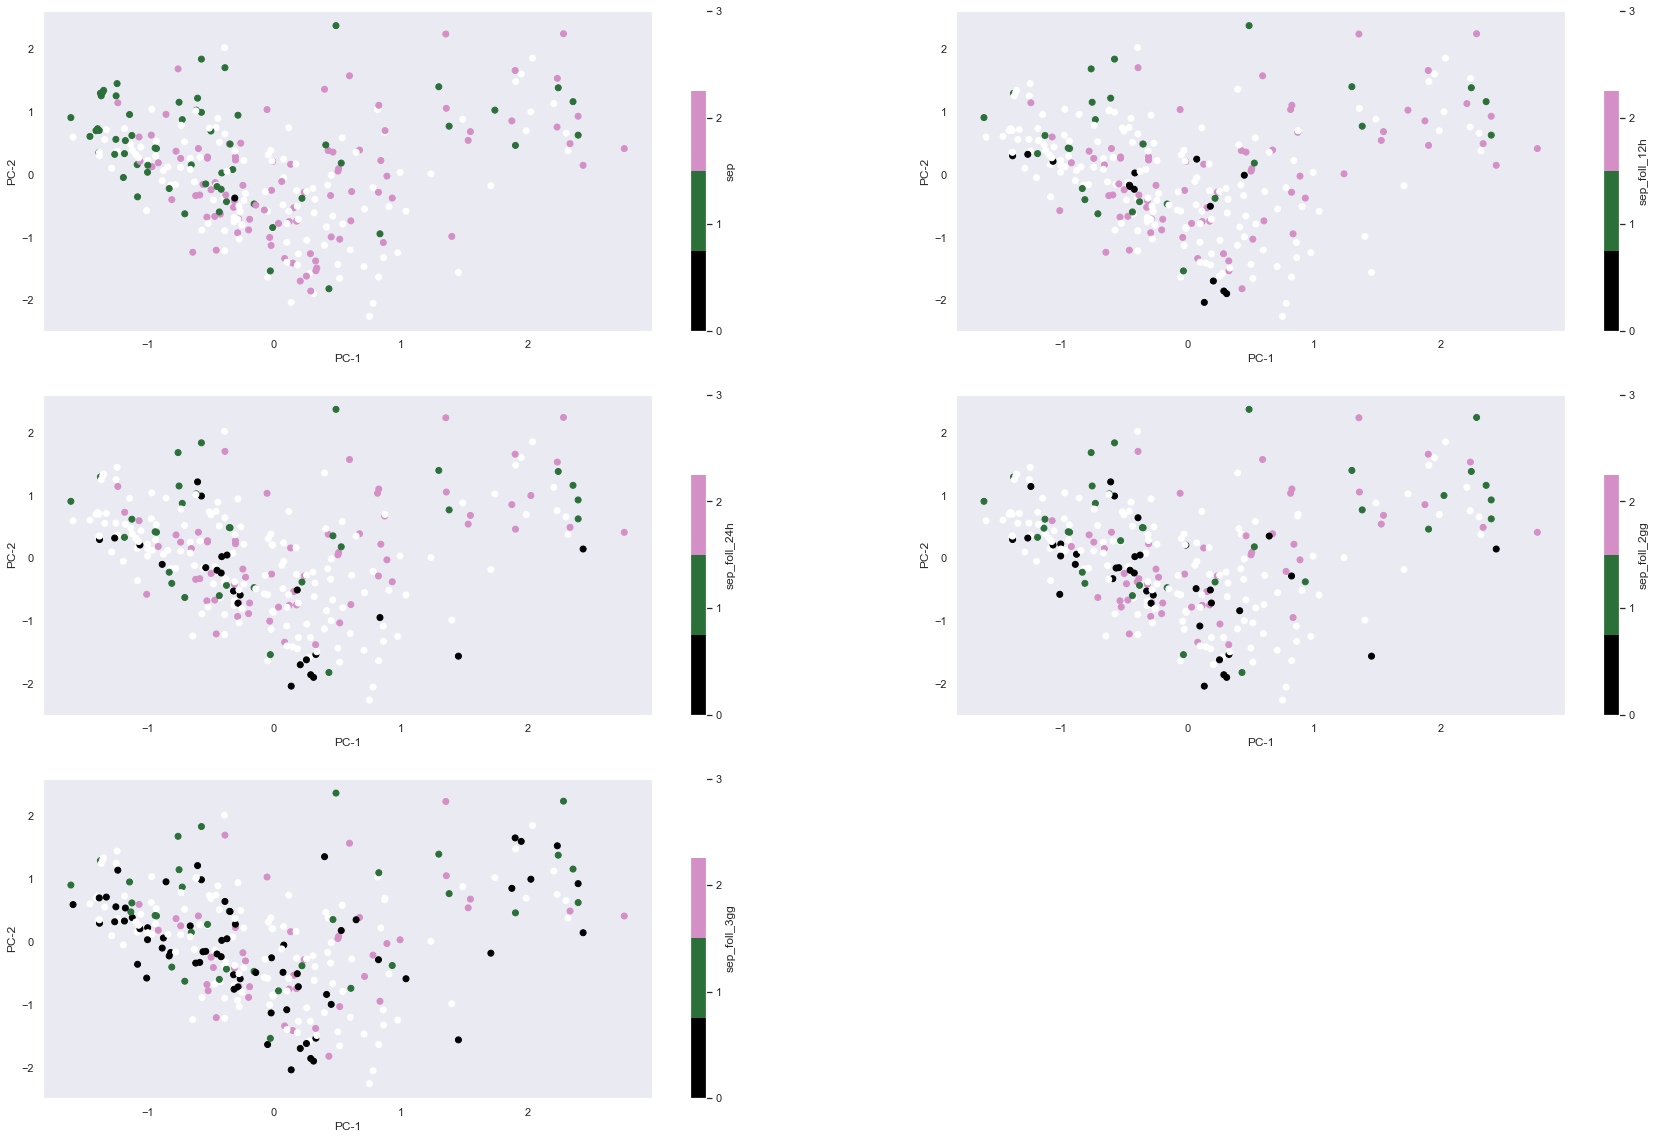

In [59]:
fig = plt.figure(figsize=(30,20))

for i in range(0,5):
    
    ax = fig.add_subplot(3, 2, i+1)
    col = df_sepsi.columns[i]
    plot2d = ax.scatter(df_pca_2d_t0.iloc[:, 0], df_pca_2d_t0.iloc[:, 1], c=df_sepsi.loc[:,col], cmap=plt.cm.get_cmap('cubehelix',len(np.unique(df_sepsi[col]))))
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    fig.colorbar(plot2d , ticks=range(len(np.unique(df_sepsi[col]))+1), label=col )
    
plt.rcParams['axes.grid'] = False

plt.show()

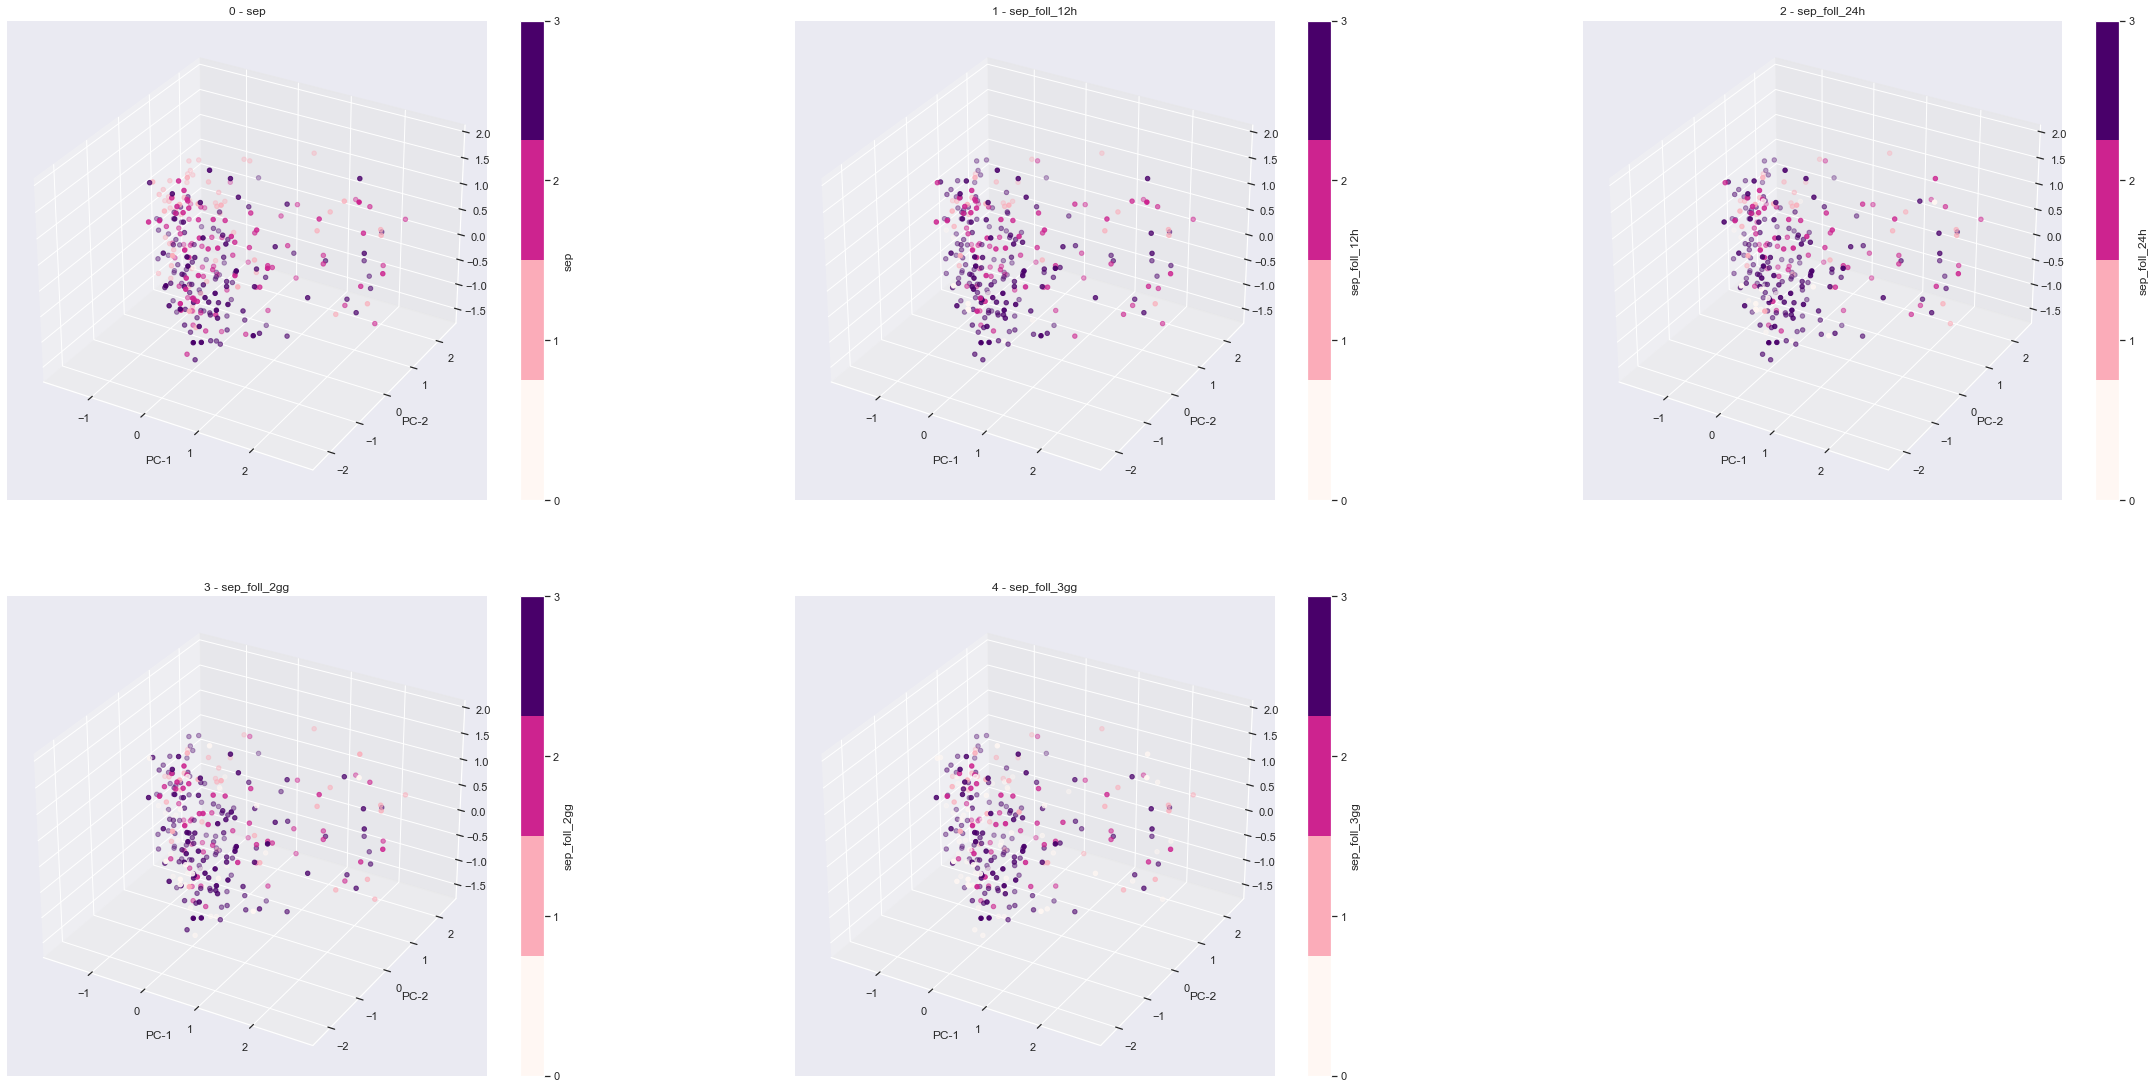

In [60]:

fig = plt.figure(figsize=(40,30))

fig3 = list()
for i in range(0,5):
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    col = df_sepsi.columns[i]

    plot3d = ax.scatter(df_pca_3d_t0.iloc[:, 0], df_pca_3d_t0.iloc[:, 1],df_pca_3d_t0.iloc[:, 2],  c=df_sepsi[col],\
               cmap=plt.cm.get_cmap('RdPu',len(np.unique(df_sepsi[col]))))
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    fig.colorbar(plot3d ,ticks=range(len(np.unique(df_sepsi[col]))+1), label=col)
    plt.title(str(i) + " - " + str(col))
    
    fig3.append(px.scatter_3d(
        df_pca_3d_t0, x=0, y=1, z=2, color=df_sepsi_1[col],
        color_discrete_sequence=px.colors.qualitative.Alphabet,
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        height=700
    ))
    fig3[i].update_layout(legend_title=col)
    fig3[i].update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            family="Courier",
            size=12,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=2
    ))

    
plt.rcParams['axes.grid'] = False

plt.show()

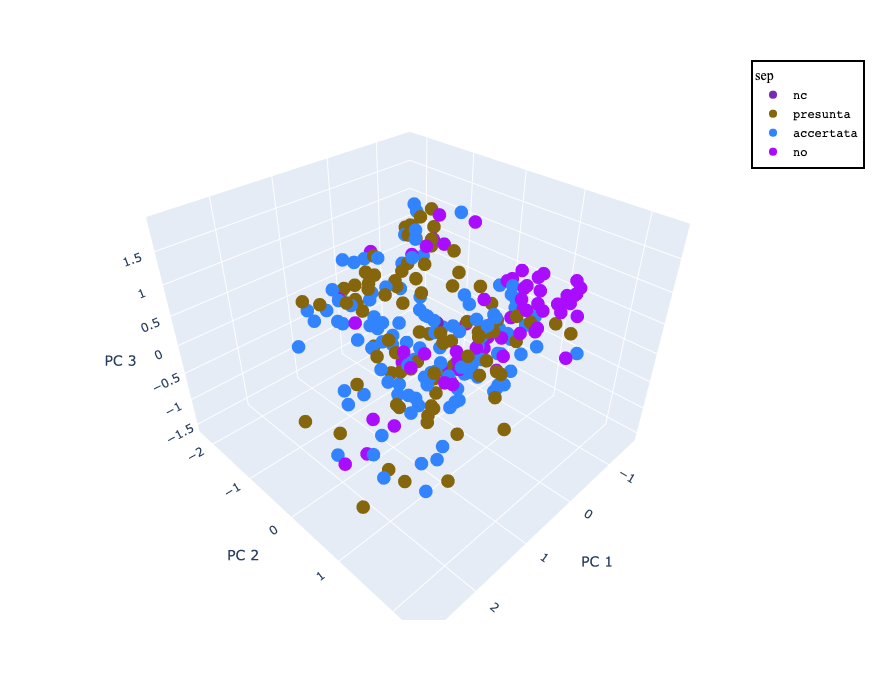

In [61]:
fig3[0]

# DA FARE

1. Percentuale mortalità rispetto al cluster
2. Percentuale di mortalità a pari del sofa score e sepsi


In [62]:
id_cluster_0 = list()
id_cluster_1 = list()
for i in range(len(kmeans_model.labels_)):
    if kmeans_model.labels_[i] == 0:
        id_cluster_0.append(personal_id[i])
    else : 
        id_cluster_1.append(personal_id[i])

## Percentuale mortalità rispetto al cluster

In [63]:
df_test = df_esiti.copy()
df_test.insert(0, "ID", personal_id, True)


In [64]:
index_1=list()
index_0 = list()
for row in df_test.index:
    if df_test['ID'].iloc[row] in id_cluster_1:
        index_1.append(df_test.index[row])
    else:
        index_0.append(df_test.index[row])

In [65]:
df_cluster_0 = df_test.copy()
df_cluster_1 = df_test.copy()

df_cluster_0.drop(index_1,inplace=True)
df_cluster_0.reset_index(inplace=True)
df_cluster_0.drop(columns='index',inplace=True)

df_cluster_1.drop(index_0,inplace=True)
df_cluster_1.reset_index(inplace=True)
df_cluster_1.drop(columns='index',inplace=True)

In [66]:
value_12h_0, count_12h_0 = np.unique(df_cluster_0['esito_12h'],return_counts=True)
value_24h_0, count_24h_0 = np.unique(df_cluster_0['esito_24h'],return_counts=True)
value_2gg_0, count_2gg_0 = np.unique(df_cluster_0['esito_2gg'],return_counts=True)
value_3gg_0, count_3gg_0 = np.unique(df_cluster_0['esito_3gg'],return_counts=True)

In [67]:
value_12h_1, count_12h_1 = np.unique(df_cluster_1['esito_12h'],return_counts=True)
value_24h_1, count_24h_1 = np.unique(df_cluster_1['esito_24h'],return_counts=True)
value_2gg_1, count_2gg_1 = np.unique(df_cluster_1['esito_2gg'],return_counts=True)
value_3gg_1, count_3gg_1 = np.unique(df_cluster_1['esito_3gg'],return_counts=True)

In [68]:
for i in range(len(value_12h_0)):
    if value_12h_0[i] == 1:
        print('La percentuali di VIVI a 12h per il cluster 0 è di : ',round(count_12h_0[i]*100/df_cluster_0.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 12h per il cluster 0 è di : ',round(count_12h_0[i]*100/df_cluster_0.shape[0]),'%')

for i in range(len(value_12h_1)):
    
    if value_12h_1[i] == 1:
        print('La percentuali di VIVI a 12h per il cluster 1 è di : ',round(count_12h_1[i]*100/df_cluster_1.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 12h per il cluster 1 è di : ',round(count_12h_1[i]*100/df_cluster_1.shape[0]),'%')

        

La percentuali di VIVI a 12h per il cluster 0 è di :  97 %
La percentuali di MORTI a 12h per il cluster 0 è di :  3 %
La percentuali di VIVI a 12h per il cluster 1 è di :  100 %


In [69]:
for i in range(len(value_24h_0)):
    if value_24h_0[i] == 1:
        print('La percentuali di VIVI a 24h per il cluster 0 è di : ',round(count_24h_0[i]*100/df_cluster_0.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 24h per il cluster 0 è di : ',round(count_24h_0[i]*100/df_cluster_0.shape[0]),'%')        

for i in range(len(value_24h_1)):
    if value_24h_1[i] == 1:
        print('La percentuali di VIVI a 24h per il cluster 1 è di : ',round(count_24h_1[i]*100/df_cluster_1.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 24h per il cluster 1 è di : ',round(count_24h_1[i]*100/df_cluster_1.shape[0]),'%')        

La percentuali di VIVI a 24h per il cluster 0 è di :  90 %
La percentuali di MORTI a 24h per il cluster 0 è di :  10 %
La percentuali di VIVI a 24h per il cluster 1 è di :  98 %
La percentuali di MORTI a 24h per il cluster 1 è di :  2 %


In [70]:
for i in range(len(value_2gg_0)):
    if value_2gg_0[i] == 1:
        print('La percentuali di VIVI a 2 giorni per il cluster 0 è di : ',round(count_2gg_0[i]*100/df_cluster_0.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 2 giorni  per il cluster 0 è di : ',round(count_2gg_0[i]*100/df_cluster_0.shape[0]),'%')        

for i in range(len(value_2gg_1)):
    if value_2gg_1[i] == 1:
        print('La percentuali di VIVI a 2 giorni per il cluster 1 è di : ',round(count_2gg_1[i]*100/df_cluster_1.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 2 giorni  per il cluster 1 è di : ',round(count_2gg_1[i]*100/df_cluster_1.shape[0]),'%')        

La percentuali di VIVI a 2 giorni per il cluster 0 è di :  85 %
La percentuali di MORTI a 2 giorni  per il cluster 0 è di :  15 %
La percentuali di VIVI a 2 giorni per il cluster 1 è di :  96 %
La percentuali di MORTI a 2 giorni  per il cluster 1 è di :  4 %


In [71]:
for i in range(len(value_3gg_0)):
    if value_3gg_0[i] == 1:
        print('La percentuali di VIVI a 24h per il cluster 0 è di : ',round(count_3gg_0[i]*100/df_cluster_0.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 24h per il cluster 0 è di : ',round(count_3gg_0[i]*100/df_cluster_0.shape[0]),'%')        

for i in range(len(value_3gg_1)):
    if value_3gg_1[i] == 1:
        print('La percentuali di VIVI a 24h per il cluster 1 è di : ',round(count_3gg_1[i]*100/df_cluster_1.shape[0]),'%')
    else:
        print('La percentuali di MORTI a 24h per il cluster 1 è di : ',round(count_3gg_1[i]*100/df_cluster_1.shape[0]),'%')        

La percentuali di VIVI a 24h per il cluster 0 è di :  79 %
La percentuali di MORTI a 24h per il cluster 0 è di :  21 %
La percentuali di VIVI a 24h per il cluster 1 è di :  87 %
La percentuali di MORTI a 24h per il cluster 1 è di :  13 %


### Percentuale mortalità a pari del sofa score

In [72]:
df_test_2 = pd.merge(df_test,df_score,right_index=True,left_index=True)

In [73]:
df_score_cluster0 = df_test_2.drop(index_1)

In [74]:
df_score_cluster0.reset_index(inplace=True)
df_score_cluster0.drop(columns=('index'),inplace=True)

In [75]:
df_score_cluster1 = df_test_2.drop(index_0)
df_score_cluster1.reset_index(inplace=True)
df_score_cluster1.drop(columns=('index'),inplace=True)

**Tempo 0**

In [76]:
fascia_1_0 = df_score_cluster0.loc[df_score_cluster0['sofa_score'] <= 7 ]

fascia_2_0 = df_score_cluster0.loc[(df_score_cluster0['sofa_score'] > 7) & (df_score_cluster0['sofa_score'] <= 14) ]

fascia_3_0 = df_score_cluster0.loc[df_score_cluster0['sofa_score'] > 14 ]

In [77]:
print('La percentuale di pazienti del cluster 0 nella fascia 1 (con sofa score compreso tra 3 e 7 è del :' ,\
      round(fascia_1_0.shape[0]*100/df_score_cluster0.shape[0]),'%')

print('La percentuale di pazienti del cluster 0 nella fascia 2 (con sofa score compreso tra 7 e 14 è del :' ,\
      round(fascia_2_0.shape[0]*100/df_score_cluster0.shape[0]),'%')

print('La percentuale di pazienti del cluster 0 nella fascia 3 (con sofa score sopra a 14 :' ,\
      round(fascia_3_0.shape[0]*100/df_score_cluster0.shape[0]),'%')

La percentuale di pazienti del cluster 0 nella fascia 1 (con sofa score compreso tra 3 e 7 è del : 3 %
La percentuale di pazienti del cluster 0 nella fascia 2 (con sofa score compreso tra 7 e 14 è del : 56 %
La percentuale di pazienti del cluster 0 nella fascia 3 (con sofa score sopra a 14 : 41 %


In [78]:
fascia_1_1 = df_score_cluster1.loc[df_score_cluster1['sofa_score'] <= 7 ]

fascia_2_1 = df_score_cluster1.loc[(df_score_cluster1['sofa_score'] > 7) & (df_score_cluster1['sofa_score'] <= 14) ]

fascia_3_1 = df_score_cluster1.loc[df_score_cluster1['sofa_score'] > 14 ]

In [79]:
print('La percentuale di pazienti del cluster 1 nella fascia 1 (con sofa score compreso tra 3 e 7 è del :' ,\
      round(fascia_1_1.shape[0]*100/df_score_cluster1.shape[0]),'%')

print('La percentuale di pazienti del cluster 1 nella fascia 2 (con sofa score compreso tra 7 e 14 è del :' ,\
      round(fascia_2_1.shape[0]*100/df_score_cluster1.shape[0]),'%')

print('La percentuale di pazienti del cluster 1 nella fascia 3 (con sofa score sopra a 14 :' ,\
      round(fascia_3_1.shape[0]*100/df_score_cluster1.shape[0]),'%')

La percentuale di pazienti del cluster 1 nella fascia 1 (con sofa score compreso tra 3 e 7 è del : 31 %
La percentuale di pazienti del cluster 1 nella fascia 2 (con sofa score compreso tra 7 e 14 è del : 58 %
La percentuale di pazienti del cluster 1 nella fascia 3 (con sofa score sopra a 14 : 11 %


In [80]:
print('La percentuale di mortalità nelle prime 12 ore nella fascia 1 del cluster 0:', \
      round(fascia_1_0[fascia_1_0['esito_12h'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nelle 24 ore nella fascia 1 del cluster 0:', \
      round(fascia_1_0[fascia_1_0['esito_24h'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nei 2 giorni nella fascia 1 del cluster 0:', \
      round(fascia_1_0[fascia_1_0['esito_2gg'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nei 3 giorni nella fascia 1 del cluster 0:', \
      round(fascia_1_0[fascia_1_0['esito_3gg'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

La percentuale di mortalità nelle prime 12 ore nella fascia 1 del cluster 0: 0 %
La percentuale di mortalità nelle 24 ore nella fascia 1 del cluster 0: 0 %
La percentuale di mortalità nei 2 giorni nella fascia 1 del cluster 0: 0 %
La percentuale di mortalità nei 3 giorni nella fascia 1 del cluster 0: 0 %


In [81]:
print('La percentuale di mortalità nelle prime 12 ore nella fascia 1 del cluster 1:', \
      round(fascia_1_1[fascia_1_1['esito_12h'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nelle 24 ore nella fascia 1 del cluster 1:', \
      round(fascia_1_1[fascia_1_1['esito_24h'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nei 2 giorni nella fascia 1 del cluster 1:', \
      round(fascia_1_1[fascia_1_1['esito_2gg'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nei 3 giorni nella fascia 1 del cluster 1:', \
      round(fascia_1_1[fascia_1_1['esito_3gg'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

La percentuale di mortalità nelle prime 12 ore nella fascia 1 del cluster 1: 0 %
La percentuale di mortalità nelle 24 ore nella fascia 1 del cluster 1: 0 %
La percentuale di mortalità nei 2 giorni nella fascia 1 del cluster 1: 0 %
La percentuale di mortalità nei 3 giorni nella fascia 1 del cluster 1: 2 %


In [82]:
print('La percentuale di mortalità nelle prime 12 ore nella fascia 2 del cluster 0:', \
      round(fascia_2_0[fascia_2_0['esito_12h'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 0:', \
      round(fascia_2_0[fascia_2_0['esito_24h'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 0:', \
      round(fascia_2_0[fascia_2_0['esito_2gg'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 0:', \
      round(fascia_2_0[fascia_2_0['esito_3gg'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

La percentuale di mortalità nelle prime 12 ore nella fascia 2 del cluster 0: 0 %
La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 0: 4 %
La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 0: 7 %
La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 0: 9 %


In [83]:
print('La percentuale di mortalità nelle prime 12 ore nella fascia 2 del cluster 1:', \
      round(fascia_2_1[fascia_2_1['esito_12h'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 1:', \
      round(fascia_2_1[fascia_2_1['esito_24h'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 1:', \
      round(fascia_2_1[fascia_2_1['esito_2gg'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 1:', \
      round(fascia_2_1[fascia_2_1['esito_3gg'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

La percentuale di mortalità nelle prime 12 ore nella fascia 2 del cluster 1: 0 %
La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 1: 2 %
La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 1: 4 %
La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 1: 9 %


In [84]:
print('La percentuale di mortalità nelle prime 12 ore nella fascia 3 del cluster 0:', \
      round(fascia_3_0[fascia_3_0['esito_12h'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 0:', \
      round(fascia_3_0[fascia_3_0['esito_24h'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 0:', \
      round(fascia_3_0[fascia_3_0['esito_2gg'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

print('La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 0:', \
      round(fascia_3_0[fascia_3_0['esito_3gg'] == 2].shape[0]*100 /df_score_cluster0.shape[0]),'%')

La percentuale di mortalità nelle prime 12 ore nella fascia 3 del cluster 0: 3 %
La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 0: 7 %
La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 0: 8 %
La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 0: 13 %


In [85]:
print('La percentuale di mortalità nelle prime 12 ore nella fascia 3 del cluster 1:', \
      round(fascia_3_1[fascia_3_1['esito_12h'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 1:', \
      round(fascia_3_1[fascia_3_1['esito_24h'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 1:', \
      round(fascia_3_1[fascia_3_1['esito_2gg'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

print('La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 1:', \
      round(fascia_3_1[fascia_3_1['esito_3gg'] == 2].shape[0]*100 /df_score_cluster1.shape[0]),'%')

La percentuale di mortalità nelle prime 12 ore nella fascia 3 del cluster 1: 0 %
La percentuale di mortalità nelle 24 ore nella fascia 2 del cluster 1: 0 %
La percentuale di mortalità nei 2 giorni nella fascia 2 del cluster 1: 0 %
La percentuale di mortalità nei 3 giorni nella fascia 2 del cluster 1: 2 %
